In [1]:
import os

import torch

torch.cuda.device_count()

import argparse
import copy
import functools
import glob
import itertools
import math
import os
import types
from collections import OrderedDict

import clip
import encoding.utils as utils
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transform
import torchvision.transforms as torch_transforms
import torchvision.transforms as transforms
from additional_utils.models import LSeg_MultiEvalModule
from encoding.datasets import test_batchify_fn
from encoding.models.sseg import BaseNet
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelCriterion, DataParallelModel
from matplotlib.backends.backend_agg import FigureCanvasAgg
from modules.lseg_module import LSegModule
from PIL import Image
from torch.nn.parallel.scatter_gather import gather
from torch.utils import data
from tqdm import tqdm

from data import get_dataset

In [2]:
from options import args

args['scale_inv'] = False
args['widehead'] = True
args['dataset'] = 'ade20k'
args['backbone'] = 'clip_vitl16_384'
args['weights'] = './checkpoints/demo_e200.ckpt'
args['ignore_index'] = 255


#change module as well since args is a dict

module = LSegModule.load_from_checkpoint(
    checkpoint_path = args['weights'],
    data_path = args['data_path'],
    dataset = args['dataset'],
    backbone = args['backbone'],
    aux = args['aux'],
    num_features = 256,
    aux_weight = 0,
    se_loss = False,
    se_weight = 0,
    base_lr = 0,
    batch_size = 1,
    max_epochs = 0,
    ignore_index = args['ignore_index'],
    dropout = 0.0,
    scale_inv = args['scale_inv'],
    augment = False,
    no_batchnorm = False,
    widehead = args['widehead'],
    widehead_hr = args['widehead_hr'],
    map_locatin = "cpu",
    arch_option = args['arch_option'],
    strict = args['strict'],
    block_depth = args['block_depth'],
    activation = args['activation'],
)

/home/zubairirshad/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint checkpoints/demo_e200.ckpt`


** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.0MiB/s]


MultiEvalModule: base_size 520, crop_size 480


  0%|          | 0/24 [00:00<?, ?it/s]

1 00001.jpg
image shape (1024, 1920, 3)
** MultiEvalModule parallel_forward phase: ['persons', ' floor', ' others'] **
** MultiEvalModule forward phase: ['persons', ' floor', ' others'] **
inference time 1.251551628112793
features torch.Size([1, 512, 1024, 1920])
text features torch.Size([3, 512])
outputs torch.Size([1, 3, 1024, 1920])


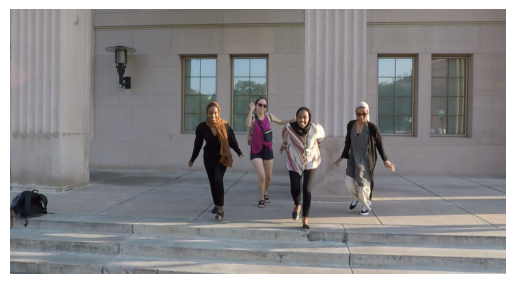

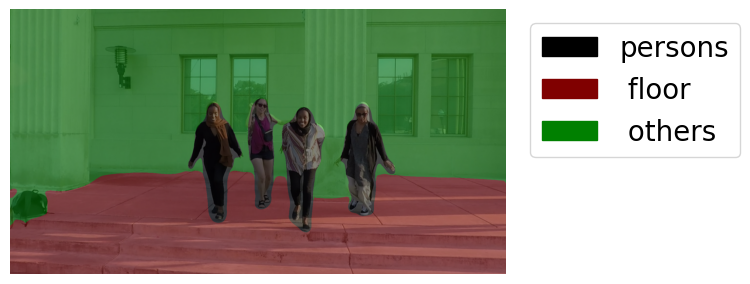

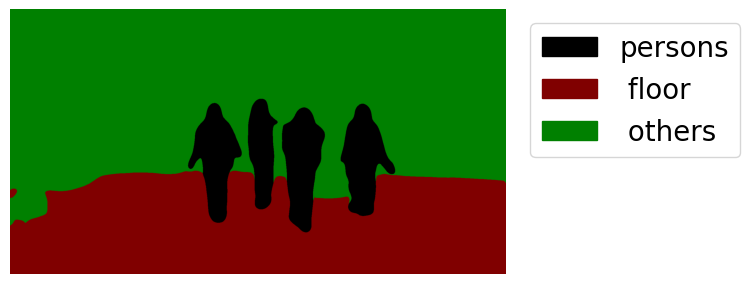

100%|██████████| 24/24 [00:01<00:00, 12.69it/s]


In [37]:
input_transform = module.val_transform
from viz_utils import *

args['cuda'] = not args['no_cuda'] and torch.cuda.is_available()
# dataloader
loader_kwargs = (
    {"num_workers": args['workers'], "pin_memory": True} if args['cuda'] else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    # [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    # if args.dataset == "citys"
    # else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]

    [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=False
).cuda()
evaluator.eval()

from tqdm import tqdm

images = []
features = []
imgdir = "/home/zubairirshad/Downloads/dynamic_scene_data_full/nvidia_data_full/Jumping/dense/images"

# out_img_feat_dir = "/data/zubair/replica/room_0/img_feat"
# out_img_feat_dir = "/data/zubair/replica/room_0/text_feat"

# os.makedirs(out_img_feat_dir, exists_ok = True)
import time
import os

# img_root = imgdir + '/' + args.room_name
# img_paths = [os.path.join(img_root, path) for path in os.listdir(img_root) if '.png' in path]


# img_paths = [os.path.join(imgdir, path) for path in os.listdir(imgdir) if '.png' in path]

img_paths = os.listdir(imgdir)
img_paths.sort()

for (k, img_name) in enumerate(tqdm(img_paths)):

    if k!=1:
        continue
    print (k, img_name)

    img_path = os.path.join(imgdir, img_name)
    pil_img = Image.open(img_path)
    image = np.array(pil_img)[...,:3]
    print("image shape", image.shape)

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((int(image.shape[0]), int(image.shape[1]))),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    image = transform(image).unsqueeze(0).cuda()

    label_src = 'persons, floor, others'

    # label_src = 'sofa, others'
    labels = []

    lines = label_src.split(',')
    for line in lines:
        label = line
        labels.append(label)

    oo = len(img_path) - 1
    while img_path[oo] != '/': oo -= 1

    start_time = time.time()
    with torch.no_grad():
        features, text_features, outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
        print("inference time", time.time()-start_time)
        predicts = [
            torch.max(output, 1)[1].cpu().numpy() 
            for output in outputs
            ]
    predict = predicts[0]

    print("features", features[0].shape)
    print("text features", text_features[0].shape)
    print("outputs", outputs[0].shape)
    img_vis = image.cpu()
    visualize_seg(predict, labels, img_vis)



image_features = features[0]
text_features = text_features[0]


In [ ]:
# # Sample image and text features (replace with your actual data)
# image_features = torch.randn(1, 512, 480, 640)
# text_features = torch.randn(5, 512)


# # Compute the similarity scores using cosine similarity
# image_features = image_features.view(512, -1).permute(1,0).float()  # Reshape the image features
# text_features = text_features[0,:].view(1, -1).float()    # Reshape the text features
# similarity_matrix = torch.mm(text_features, image_features.T)

# # Find the best similarity score for each text feature
# best_similarity_scores, best_matching_indices = torch.max(similarity_matrix, dim=1)

# # Convert the PyTorch tensor to a NumPy array
# similarity_scores_array = best_similarity_scores.cpu().numpy()

# normalized features

imshape = image_features.shape
print(imshape)

image_features = image_features.permute(0,2,3,1).reshape(-1, imshape[1])
print("image_features", image_features.shape)

image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

logits_per_image = image_features.half() @ text_features.t()

print("logits_per_image", logits_per_image.shape)
out = logits_per_image.float().view(imshape[0], imshape[2], imshape[3], -1).permute(0,3,1,2)

print("out", out.shape)

predict = torch.max(out, 1)[1].cpu().numpy()
visualize_seg(predict, labels, img_vis)
# plt.imshow()
# Create a heatmap plot
# plt.imshow(out.reshape(1, -1), cmap='viridis', aspect='auto')
# plt.colorbar()
# plt.title('Best Similarity Heatmap')
# plt.xlabel('Image Features')
# plt.ylabel('Text Features')
# plt.show()
